<a href="https://colab.research.google.com/github/trisha311/Portfolio/blob/master/NLP_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I used the Women's E-Commerce Clothing Reviews Data Set from Kaggle to create a models with both text and categorical data to predict the age of a reviewer.  The features included categorical classes for the department and division assoicated with the reviewed item along with a numeric rating of the item.

A link to the dataset can be found below:
https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews


In [122]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import spacy
import re
import nltk
import warnings
warnings.filterwarnings("ignore")

!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [125]:
from google.colab import files
uploaded = files.upload()

import io
df = pd.read_csv('/content/drive/My Drive/Womens Clothing E-Commerce Reviews.csv')

Saving Womens Clothing E-Commerce Reviews.csv to Womens Clothing E-Commerce Reviews (1).csv


In [126]:
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [127]:
df[0:2]

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses


In [0]:
#reducing dataframe from over 20,000 rows to 6,000 rows for computational efficiency
df = df[0:6000]

In [129]:
df.tail()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
5995,5995,873,53,Cute but thin fabric,"Love the style and cut of this top, but fabric...",4,1,1,General,Tops,Knits
5996,5996,873,58,Flattering shape,I bought 2 in the store. i usually order larg...,5,1,0,General,Tops,Knits
5997,5997,839,23,Cute top,"I didn't love it enough to buy it, but did thi...",4,1,14,General,Tops,Blouses
5998,5998,873,23,Cute tank,I did not purchase because it was too low cut ...,4,1,5,General,Tops,Knits
5999,5999,839,22,Very flattering!,"Great fit! for reference, i am 5'7"", 160 lbs a...",5,1,0,General,Tops,Blouses


In [130]:
len(df)

6000

In [0]:
#drop unnamed anc clothing id
df = df.drop(['Unnamed: 0', 'Clothing ID'], axis=1)

In [132]:
df.head(3)

,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses


In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Age                      6000 non-null   int64 
 1   Title                    5014 non-null   object
 2   Review Text              5784 non-null   object
 3   Rating                   6000 non-null   int64 
 4   Recommended IND          6000 non-null   int64 
 5   Positive Feedback Count  6000 non-null   int64 
 6   Division Name            6000 non-null   object
 7   Department Name          6000 non-null   object
 8   Class Name               6000 non-null   object
dtypes: int64(4), object(5)
memory usage: 422.0+ KB


In [134]:
df.isnull().sum()

Age                          0
Title                      986
Review Text                216
Rating                       0
Recommended IND              0
Positive Feedback Count      0
Division Name                0
Department Name              0
Class Name                   0
dtype: int64

In [135]:
df['Class Name'].unique()

array(['Intimates', 'Dresses', 'Pants', 'Blouses', 'Knits', 'Outerwear',
       'Lounge', 'Sweaters', 'Skirts', 'Fine gauge', 'Sleep', 'Jackets',
       'Swim', 'Trend', 'Jeans', 'Legwear', 'Shorts', 'Layering',
       'Casual bottoms'], dtype=object)

In [0]:
#I will leave the missing data for Title and Review Text as is.
#I will use fill all missing division, department, and class names with their modes
df['Class Name'].fillna(df['Class Name'].mode()[0], inplace=True)

In [0]:
df['Department Name'].fillna(df['Department Name'].mode()[0], inplace=True)

In [0]:
df['Division Name'].fillna(df['Division Name'].mode()[0], inplace=True)

In [139]:
df.isnull().sum()

Age                          0
Title                      986
Review Text                216
Rating                       0
Recommended IND              0
Positive Feedback Count      0
Division Name                0
Department Name              0
Class Name                   0
dtype: int64

In [0]:
#create dummy variables for categorical features
df = pd.concat([df, pd.get_dummies(df['Division Name'], prefix='Division Name', drop_first=True)],axis=1)
dummy_column_names = list(pd.get_dummies(df['Division Name'], prefix='Division Name', drop_first=True).columns)

In [141]:
df.head(3)

,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Division Name_General Petite,Division Name_Initmates
0,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,0,1
1,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,0,0
2,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,0,0


In [0]:
df = pd.concat([df, pd.get_dummies(df['Department Name'], prefix='Department Name', drop_first=True)],axis=1)
dummy_column_names = dummy_column_names + list(pd.get_dummies(df['Department Name'], prefix='Department Name', drop_first=True).columns)

In [143]:
df.head(3)

,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Division Name_General Petite,Division Name_Initmates,Department Name_Dresses,Department Name_Intimate,Department Name_Jackets,Department Name_Tops,Department Name_Trend
0,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,0,1,0,1,0,0,0
1,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,0,0,1,0,0,0,0
2,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,0,0,1,0,0,0,0


In [0]:
df = pd.concat([df, pd.get_dummies(df['Class Name'], prefix='Class Name', drop_first=True)],axis=1)
dummy_column_names = dummy_column_names + list(pd.get_dummies(df['Class Name'], prefix='Class Name', drop_first=True).columns)

In [145]:
df.head(3)

,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Division Name_General Petite,Division Name_Initmates,Department Name_Dresses,Department Name_Intimate,Department Name_Jackets,Department Name_Tops,Department Name_Trend,Class Name_Casual bottoms,Class Name_Dresses,Class Name_Fine gauge,Class Name_Intimates,Class Name_Jackets,Class Name_Jeans,Class Name_Knits,Class Name_Layering,Class Name_Legwear,Class Name_Lounge,Class Name_Outerwear,Class Name_Pants,Class Name_Shorts,Class Name_Skirts,Class Name_Sleep,Class Name_Sweaters,Class Name_Swim,Class Name_Trend
0,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


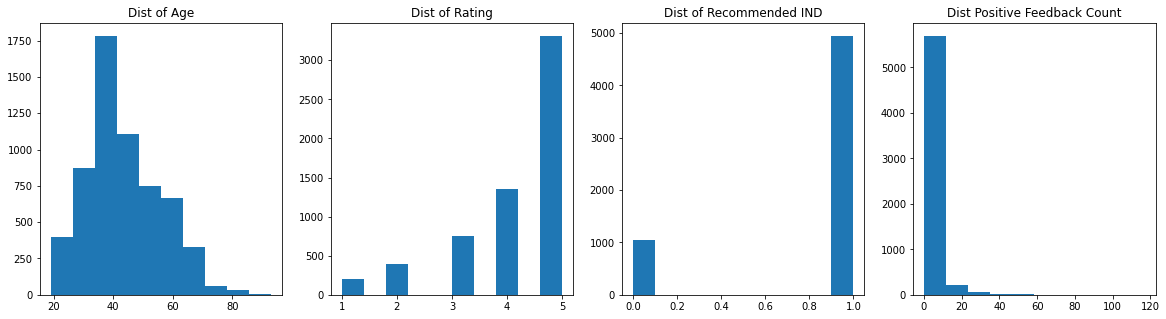

In [146]:
#data distributions for features
plt.figure(figsize=(20,5))

plt.subplot(141)
plt.hist(df['Age'])
plt.title('Dist of Age')

plt.subplot(142)
plt.hist(df['Rating'])
plt.title('Dist of Rating')

plt.subplot(143)
plt.hist(df['Recommended IND'])
plt.title('Dist of Recommended IND')


plt.subplot(144)
plt.hist(df['Positive Feedback Count'])
plt.title('Dist Positive Feedback Count')

plt.show()

Based on the above distributions, age is the only feature that is normally distributed.  It also appears that the majority of ratings and recommendations are positive.

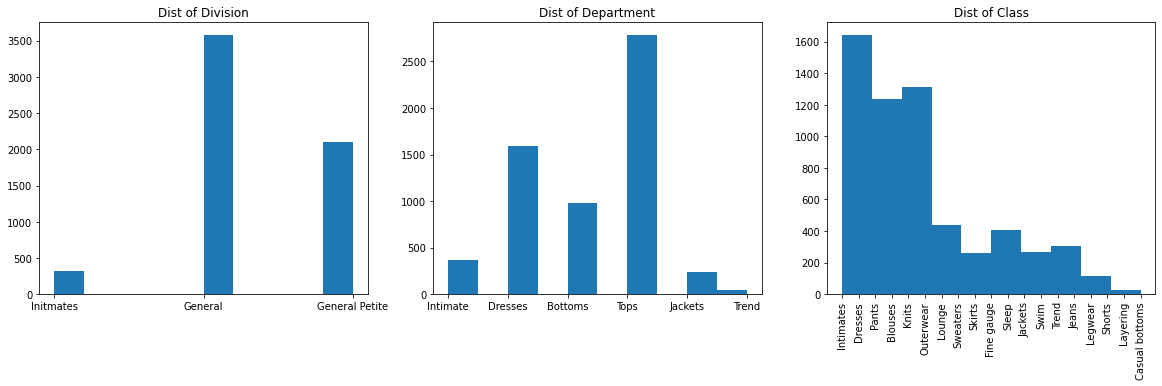

In [147]:
#dist of categorical features
plt.figure(figsize=(20,5))

plt.subplot(131)
plt.hist(df['Division Name'])
plt.title('Dist of Division')

plt.subplot(132)
plt.hist(df['Department Name'])
plt.title('Dist of Department')

plt.subplot(133)
plt.hist(df['Class Name'])
plt.title('Dist of Class')
plt.xticks(rotation='vertical')

plt.show()

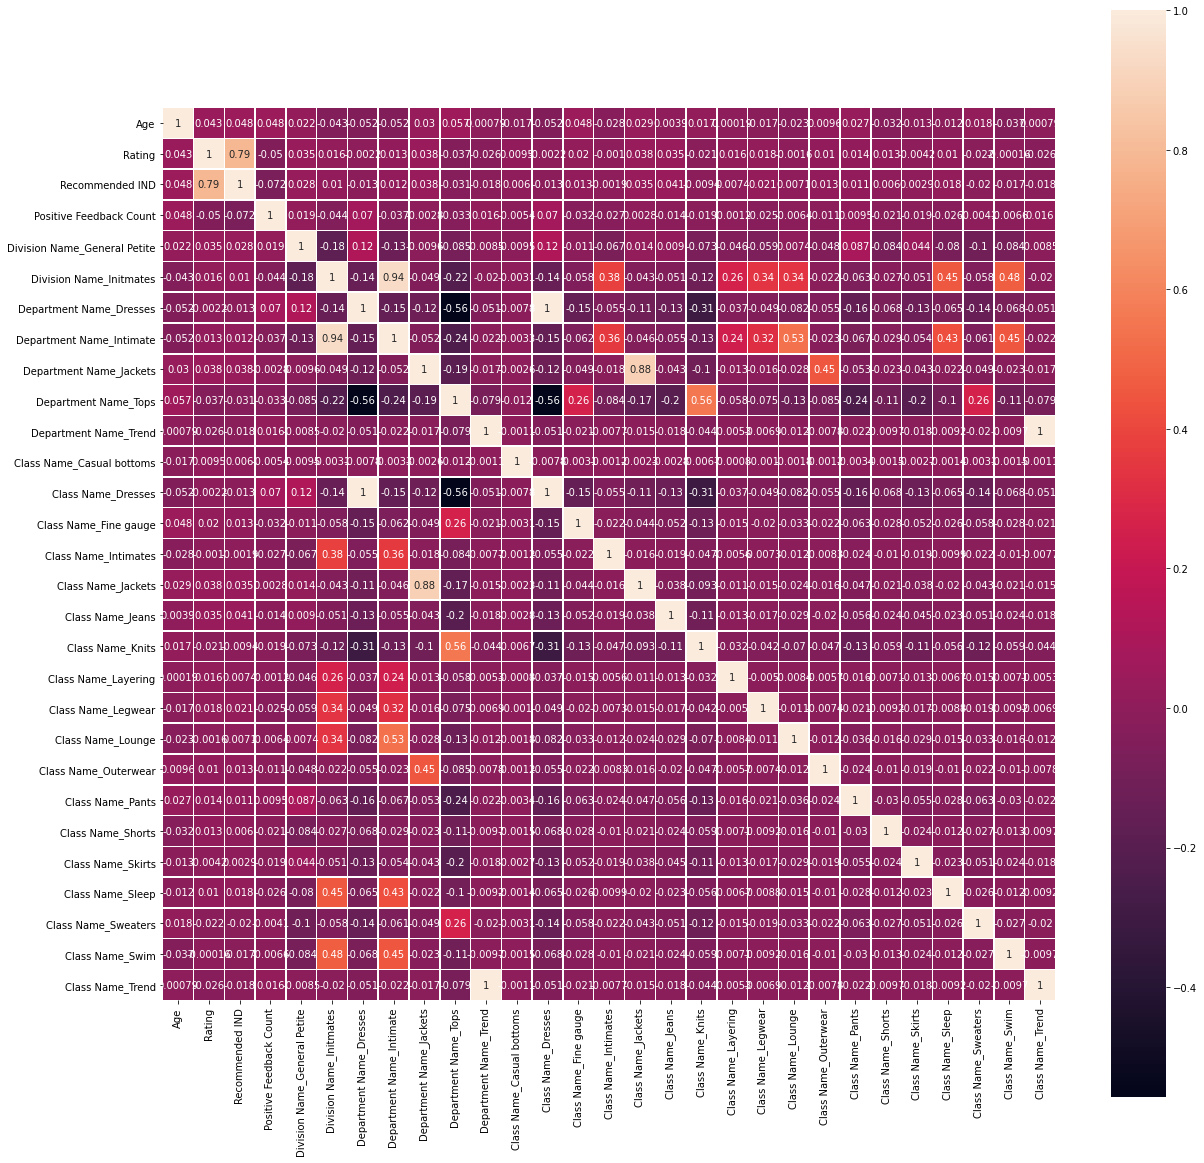

In [148]:
#correlation matrix
import seaborn as sns

correlation_matrix = df.corr()

plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix, square=True, annot=True, linewidths=.5)

There is a strong correlation between recommended IND and rating, which makes sense - since someone who highly rates an item is very likely to recommend that item to another person.
The other strongest correlations beteween features occured between classes and departments.  For instance "Class Name Jacket" had a .82 correlation with "Department Jacket", which is to be expected.

In [149]:
df['Review Text'][0]

'Absolutely wonderful - silky and sexy and comfortable'

In [0]:
#clean text and put in list

def clean_text(text):
    text = re.sub("[^a-zA-Z]",  # Search for all non-letters
                          " ",          # Replace all non-letters with spaces
                          str(text))
    text = re.sub(r'--',' ',text)
    return text

In [151]:
len(df)

6000

In [0]:
df['clean_review_text'] = df['Review Text'].map(lambda x: clean_text(x))

In [153]:
df.head(2)

,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Division Name_General Petite,Division Name_Initmates,Department Name_Dresses,Department Name_Intimate,Department Name_Jackets,Department Name_Tops,Department Name_Trend,Class Name_Casual bottoms,Class Name_Dresses,Class Name_Fine gauge,Class Name_Intimates,Class Name_Jackets,Class Name_Jeans,Class Name_Knits,Class Name_Layering,Class Name_Legwear,Class Name_Lounge,Class Name_Outerwear,Class Name_Pants,Class Name_Shorts,Class Name_Skirts,Class Name_Sleep,Class Name_Sweaters,Class Name_Swim,Class Name_Trend,clean_review_text
0,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Absolutely wonderful silky and sexy and comf...
1,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Love this dress it s sooo pretty i happene...


In [0]:
nlp = spacy.load('en')

In [0]:
def create_doc(text):
  doc = nlp(text)
  return doc

In [0]:
df['review_doc'] = df['clean_review_text'].map(lambda x: create_doc(x))

In [0]:
import nltk

In [158]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [159]:
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
# get rid off stop words and punctuation
# and lemmatize the tokens
for i, sentence in enumerate(df["review_doc"]):
    df.loc[i, "review_doc"] = " ".join(
        [token.lemma_ for token in sentence if not token.is_punct and not token.is_stop])

In [161]:
df.head()

,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Division Name_General Petite,Division Name_Initmates,Department Name_Dresses,Department Name_Intimate,Department Name_Jackets,Department Name_Tops,Department Name_Trend,Class Name_Casual bottoms,Class Name_Dresses,Class Name_Fine gauge,Class Name_Intimates,Class Name_Jackets,Class Name_Jeans,Class Name_Knits,Class Name_Layering,Class Name_Legwear,Class Name_Lounge,Class Name_Outerwear,Class Name_Pants,Class Name_Shorts,Class Name_Skirts,Class Name_Sleep,Class Name_Sweaters,Class Name_Swim,Class Name_Trend,clean_review_text,review_doc
0,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Absolutely wonderful silky and sexy and comf...,absolutely wonderful silky sexy comfortable
1,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Love this dress it s sooo pretty i happene...,love dress s sooo pretty happen find sto...
2,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,I had such high hopes for this dress and reall...,high hope dress want work initially order pe...
3,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,I love love love this jumpsuit it s fun fl...,love love love jumpsuit s fun flirty ...
4,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,This shirt is very flattering to all due to th...,shirt flattering adjustable tie perfect leng...


In [0]:
#use tf-idf to vectorize the text data from the reviews

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_df=0.5, min_df=2, use_idf=True, norm=u'l2', smooth_idf=True)


# applying the vectorizer
X = vectorizer.fit_transform(df["review_doc"])

tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

In [0]:
frames=[df, tfidf_df]
final_df = pd.concat(frames, axis=1)

In [164]:
final_df.head()

,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Division Name_General Petite,Division Name_Initmates,Department Name_Dresses,Department Name_Intimate,Department Name_Jackets,Department Name_Tops,Department Name_Trend,Class Name_Casual bottoms,Class Name_Dresses,Class Name_Fine gauge,Class Name_Intimates,Class Name_Jackets,Class Name_Jeans,Class Name_Knits,Class Name_Layering,Class Name_Legwear,Class Name_Lounge,Class Name_Outerwear,Class Name_Pants,Class Name_Shorts,Class Name_Skirts,Class Name_Sleep,Class Name_Sweaters,Class Name_Swim,Class Name_Trend,clean_review_text,review_doc,aa,abdoman,ability,able,...,wrestle,wrinkle,wrinkled,wrinkly,wrist,write,wrong,xl,xls,xmas,xs,xsmall,xsp,xspetite,xx,xxl,xxs,xxsp,yarn,yay,yeah,year,yellow,yes,yesterday,yike,yo,yoga,yoke,young,youthful,yummy,zag,zero,zig,zip,zipper,zippered,zone,zoom
0,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Absolutely wonderful silky and sexy and comf...,absolutely wonderful silky sexy comfortable,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
1,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Love this dress it s sooo pretty i happene...,love dress s sooo pretty happen find sto...,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
2,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,I had such high hopes for this dress and reall...,high hope dress want work initially order pe...,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.146981,0.131392,0.0,0.0,0.0
3,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,I love love love this jumpsuit it s fun fl...,love love love jumpsuit s fun flirty ...,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
4,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,This shirt is very flattering to all due to th...,shirt flattering adjustable tie perfect leng...,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0


In [0]:
X = vectorizer.fit_transform(df["review_doc"])
tfidf_df2 = pd.DataFrame(X.toarray().transpose(),index=vectorizer.get_feature_names())

In [172]:
df.columns

Index(['Age', 'Title', 'Review Text', 'Rating', 'Recommended IND',
       'Positive Feedback Count', 'Division Name', 'Department Name',
       'Class Name', 'Division Name_General Petite', 'Division Name_Initmates',
       'Department Name_Dresses', 'Department Name_Intimate',
       'Department Name_Jackets', 'Department Name_Tops',
       'Department Name_Trend', 'Class Name_Casual bottoms',
       'Class Name_Dresses', 'Class Name_Fine gauge', 'Class Name_Intimates',
       'Class Name_Jackets', 'Class Name_Jeans', 'Class Name_Knits',
       'Class Name_Layering', 'Class Name_Legwear', 'Class Name_Lounge',
       'Class Name_Outerwear', 'Class Name_Pants', 'Class Name_Shorts',
       'Class Name_Skirts', 'Class Name_Sleep', 'Class Name_Sweaters',
       'Class Name_Swim', 'Class Name_Trend', 'clean_review_text',
       'review_doc'],
      dtype='object')

In [174]:
#term matrix with TF-IDF
tfidf_df2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,5960,5961,5962,5963,5964,5965,5966,5967,5968,5969,5970,5971,5972,5973,5974,5975,5976,5977,5978,5979,5980,5981,5982,5983,5984,5985,5986,5987,5988,5989,5990,5991,5992,5993,5994,5995,5996,5997,5998,5999
aa,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abdoman,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ability,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
able,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abo,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zip,0.0,0.0,0.146981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.161966,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zipper,0.0,0.0,0.131392,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.193095,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.512358,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zippered,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zone,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
tfidf_df2["sum"] = tfidf_df2. sum(axis=1)
  

In [176]:
tfidf_df2.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,5961,5962,5963,5964,5965,5966,5967,5968,5969,5970,5971,5972,5973,5974,5975,5976,5977,5978,5979,5980,5981,5982,5983,5984,5985,5986,5987,5988,5989,5990,5991,5992,5993,5994,5995,5996,5997,5998,5999,sum
aa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.513014
abdoman,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.547106


In [0]:
matrix_sum=pd.DataFrame(tfidf_df2['sum'],tfidf_df2.index, )

In [192]:
matrix_sum

,sum
aa,0.513014
abdoman,0.547106
ability,0.514851
able,19.968088
abo,0.545837
...,...
zip,14.481264
zipper,27.763599
zippered,0.602844
zone,0.619459


In [0]:
matrix_sum.sort_values(by=['sum'], inplace=True)

In [194]:
matrix_sum

,sum
bus,0.303505
bathe,0.410368
creative,0.435206
sided,0.450924
underestimate,0.457202
...,...
wear,235.868480
size,240.339256
fit,249.400377
love,254.480898


The most important words in determining meaning of the text data from this data are 'dress', 'love', 'fit', 'size', and 'wear'.  Where with the words with the least importance are 'bus', 'bathe', 'creative', and 'sided' based on their term frequency–inverse document frequencies in the clothing reviews.

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split

In [0]:
Y = final_df['Age']
X = np.array(final_df.drop(['Title','Review Text', 'Division Name', 'Department Name', 'Class Name', 'clean_review_text', 'review_doc'], 1))

In [0]:
# We split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=123)


In [168]:
# Models
lr = LogisticRegression()
rfc = RandomForestClassifier()
gbc = GradientBoostingClassifier()

lr.fit(X_train, y_train)
rfc.fit(X_train, y_train)
gbc.fit(X_train, y_train)

print("----------------------Logistic Regression Scores----------------------")
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

print("----------------------Random Forest Scores----------------------")
print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

print("----------------------Gradient Boosting Scores----------------------")
print('Training set score:', gbc.score(X_train, y_train))
print('\nTest set score:', gbc.score(X_test, y_test))

----------------------Logistic Regression Scores----------------------
Training set score: 0.12222222222222222

Test set score: 0.08
----------------------Random Forest Scores----------------------
Training set score: 1.0

Test set score: 0.41541666666666666
----------------------Gradient Boosting Scores----------------------
Training set score: 1.0

Test set score: 0.9666666666666667


The Gradient Boosting Model had a very strong performance, and was only slightly overfit to the training data.